In [1]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import sys

sys.path.append("../trimmingSession")
sys.path.append("~/.local/share/fonts")
from util import *
from stationUtil import *
from graph import *

len(subway_graph) == len(interval_time) :  True


In [2]:
# THIS CODE FROM 11.ipynd

g_dist = dist_weight_graph()

f_list = glob("../trimmed_data/A001_20*.csv.*")
demand = [loadPickle(p) for p in f_list]


def od_metric(scode_start, scode_end):
    for d in demand:
        try:
            return d[(scode_start, scode_end)] + d[(scode_end, scode_start)]
        except:
            return 0


def unit_tranfer_flux_metric(scode_start, scode_end, g_dist=g_dist):
    UNITFACTOR_P1KM_TO_1KM = 1 / 10
    path_dist = (
        calc_total_path_weight(g_dist, scode_start, scode_end) * UNITFACTOR_P1KM_TO_1KM
    )
    path_od = od_metric(scode_start, scode_end)
    return path_dist * path_od

In [3]:
# Calc Flux Metric
flux_metric = []
s_namecode = loadPickle("../trimmed_data/stationNameCode.pickel").values()
for target_scode in s_namecode:
    arr = []
    for calc_scode in s_namecode:
        flux = unit_tranfer_flux_metric(target_scode, calc_scode)
        try:
            arr.append(flux)
        except:
            pass
    flux_metric.append([target_scode, sum(arr)])

df = pd.DataFrame(flux_metric, columns=["scode", "flux_metric"])
df_transfer_metric = df.sort_values(by="scode").reset_index(drop=True)

In [4]:
# 역명을 코드로 변환하기 위한 data
station_namecode_table = pd.read_json("../trimmed_data/stationCodeNameLine.json")
station_namecode_table["StationName"] = station_namecode_table["StationName"].apply(
    lambda _X: _X.replace("·", ".").replace("국제금융센터", "국제금융")
)

# 잠재수요특성 불러오가
implicit_metric = pd.read_csv(
    "../trimmed_data/역별_잠재수요특성_합계.csv", encoding="EUC-KR"
)

# Name to Code Convert
replace_relation = {
    r.StationName: int(r.StationCode)
    for r in station_namecode_table.loc[:, ["StationName", "StationCode"]].itertuples()
}
column_rename_relation = {
    "각 역의 잠재수요특성": "implicit_metric",
    "StationName": "scode",
}

df_implicit_metric = implicit_metric.replace(replace_relation)
df_implicit_metric = df_implicit_metric.rename(columns=column_rename_relation)
df_implicit_metric = df_implicit_metric.sort_values(by="scode").reset_index(drop=True)

df_implicit_metric.head()

,LineCode,scode,implicit_metric
0,1,95,53626.31105
1,1,96,91542.13840
2,1,97,154919.42510
3,1,98,217571.13860
4,1,99,220428.80550


In [5]:
df_metric = df_transfer_metric.copy(deep=True)
df_metric["implicit_metric"] = df_implicit_metric["implicit_metric"]
df_metric["LineCode"] = df_metric["scode"].apply(get_line)

df_metric.head()

,scode,flux_metric,implicit_metric,LineCode
0,95,3173245.0,53626.31105,1
1,96,2285062.6,91542.13840,1
2,97,2987031.8,154919.42510,1
3,98,1818186.4,217571.13860,1
4,99,2055180.6,220428.80550,1


In [6]:
def save(TARGET_LINE):
    import matplotlib.pyplot as plt

    df_metric_norm = df_metric.copy(deep=True)
    df_metric_norm = df_metric_norm[df_metric_norm["LineCode"] == TARGET_LINE]

    # Normalize
    df_metric_norm.loc[:, "flux_metric":"implicit_metric"] = (
        df_metric_norm.loc[:, "flux_metric":"implicit_metric"]
        - df_metric_norm.loc[:, "flux_metric":"implicit_metric"].min()
    ) / (
        df_metric_norm.loc[:, "flux_metric":"implicit_metric"].max()
        - df_metric_norm.loc[:, "flux_metric":"implicit_metric"].min()
    )

    # Exclue End of Station
    IS_END_OF_STATION = [95, 134, 201, 243, 301, 317, 401, 414]
    TARGET_ANALY = df_metric_norm.loc[:, "scode"].to_list()
    for del_target in IS_END_OF_STATION:
        if del_target in line_num_to_range(TARGET_LINE):
            TARGET_ANALY.pop(TARGET_ANALY.index(del_target))
    df_metric_norm = df_metric_norm[
        df_metric_norm["scode"].apply(lambda _X: _X in TARGET_ANALY)
    ]

    ax = df_metric_norm.plot.scatter(x="flux_metric", y="implicit_metric")

    fig = ax.get_figure()
    fig.savefig(f"line{TARGET_LINE}_transfer_flux_scatter.svg", format="svg")

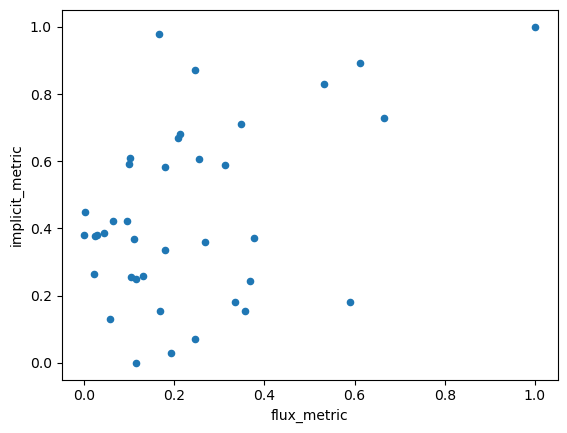

In [7]:
save(1)

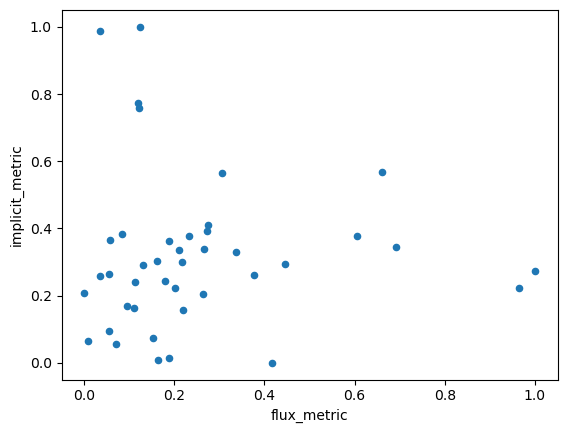

In [8]:
save(2)

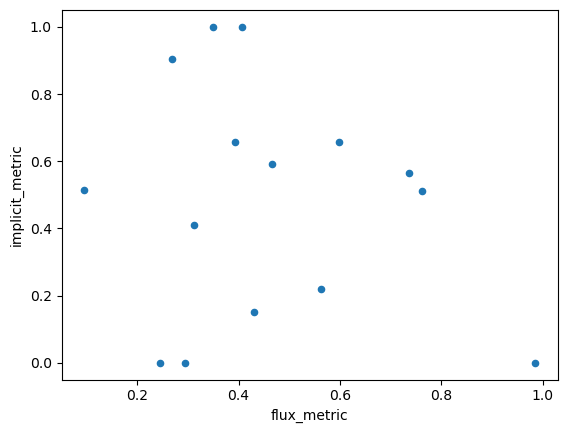

In [9]:
save(3)

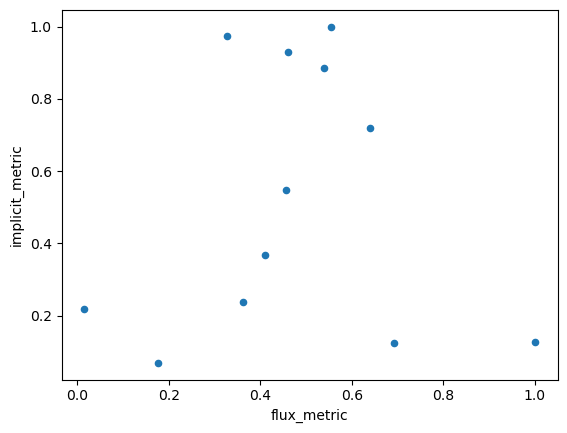

In [10]:
save(4)